In [2]:
import time
from re import I
import wandb
import datetime
import pdb
from plotly import express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from logging import info, debug
from tkinter import W
import numpy as np
import os
import logging
import numpy as np
from tqdm import tqdm
import matplotlib
from PIL import Image
from skimage import io
import pprint
from models.utils import show_progress
import numpy as np
from logging import log, info, debug
from PIL import Image
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2 as cv
import sys
from models.models import build_resnet, build_siamese_autoencoder
from losses import DiceLoss
from metrics import DiceMetric
from matplotlib import pyplot as plt
from params import *
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
# input channel 
INPUT_SHAPE = (256, 256, 3)
IMAGE_H_W = (256, 256)

def build_in_channel():
    inputs = Input(shape=INPUT_SHAPE)
    out_0 = Conv2D(16, (2, 2), padding='same')(inputs)
    out_0 = Conv2D(16, (2, 2), padding='same')(out_0)

    # shape = 256, 256, 16

    out_1 = MaxPooling2D((2, 2))(out_0)
    # shape = 128, 128, 16
    # 2x2 MaxPool HALVES w and h

    out_1 = Conv2D(16, (2, 2), padding='same')(out_1)
    out_1 = Conv2D(32, (2, 2), padding='same')(out_1)
    out_1 = Conv2D(32, (2, 2), padding='same')(out_1)
    # shape = 128, 128, 32

    out_2 = MaxPooling2D((2, 2))(out_1)
    # shape = 64, 64, 32

    out_2 = Conv2D(32, (2, 2), padding='same')(out_2)
    out_2 = Conv2D(64, (2, 2), padding='same')(out_2)
    out_2 = Conv2D(64, (2, 2), padding='same')(out_2)
    out_2 = Conv2D(64, (2, 2), padding='same')(out_2)
    # shape = 64, 64, 64

    out_3 = MaxPooling2D((2, 2))(out_2)
    # shape = 32, 32, 64

    out_3 = Conv2D(64, (2, 2),   padding='same')(out_3)
    out_3 = Conv2D(128, (2, 2),  padding='same')(out_3)
    out_3 = Conv2D(128, (2, 2),  padding='same')(out_3)
    out_3 = Conv2D(128, (2, 2),  padding='same')(out_3)
    # shape = 32, 32, 128

    return Model(inputs=inputs, outputs=(out_0, out_1, out_2, out_3))

    

def build_model(NUM_CLASSES=2):    
    left_in = Input(shape=INPUT_SHAPE)
    right_in = Input(shape=INPUT_SHAPE)
    
    # shared weights
    fe = build_in_channel()
    
    left_out, right_out = fe(left_in), fe(right_in)
    
    (l_out_0, l_out_1, l_out_2, l_out_3) = left_out
    (r_out_0, r_out_1, r_out_2, r_out_3) = right_out
    
    output = subtract([l_out_3, r_out_3])
    # shape = 32, 32, 128

    l_out_3 = MaxPooling2D((2, 2), padding='same')(l_out_3)
    # shape = 16, 16, 128
    l_out_3 = Conv2DTranspose(128, 2, padding='same')(l_out_3)
    # shape = 16, 16, 128
    l_out_3 = Conv2DTranspose(128, 2, padding='same')(l_out_3)
    # shape = 16, 16, 128
    l_out_3 = UpSampling2D((2, 2))(l_out_3)
    # shape = 32, 32, 128

    diff_3 = subtract([l_out_3, r_out_3])
    output = concatenate([output, diff_3])
    # shape = 32, 32, 256

    output = Conv2DTranspose(256, 2, padding='same')(output)
    # shape = 32, 32, 256
    output = Conv2DTranspose(128, 2, padding='same')(output)
    # shape = 32, 32, 128
    output = Conv2DTranspose(128, 2, padding='same')(output)
    # shape = 32, 32, 128
    output = Conv2DTranspose(64, 2, padding='same')(output)
    # shape = 32, 32, 64
    output = Conv2DTranspose(64, 2, padding='same')(output)
    # shape = 32, 32, 64
    output = Conv2DTranspose(64, 2, padding='same')(output)
    # shape = 32, 32, 64
    output = UpSampling2D((2, 2))(output)
    # shape = 64, 64, 64

    diff_2 = subtract([l_out_2, r_out_2])
    output = concatenate([output, diff_2])
    # shape = 64, 64, 128

    output = Conv2DTranspose(128, (2, 2), padding='same')(output)
    output = Conv2DTranspose(64, (2, 2), padding='same')(output)
    output = Conv2DTranspose(64, (2, 2), padding='same')(output)
    output = Conv2DTranspose(32, (2, 2), padding='same')(output)
    output = Conv2DTranspose(32, (2, 2), padding='same')(output)
    output = Conv2DTranspose(32, (2, 2), padding='same')(output)
    # shape = 64, 64, 32

    output = UpSampling2D((2, 2))(output)
    # shape = 128, 128, 32

    diff_1 = subtract([l_out_1, r_out_1])
    output = concatenate([output, diff_1])
    # shape = 128, 128, 64

    output = Conv2DTranspose(64, (2, 2), padding='same')(output)
    output = Conv2DTranspose(32, (2, 2), padding='same')(output)
    output = Conv2DTranspose(16, (2, 2), padding='same')(output)
    output = Conv2DTranspose(16, (2, 2), padding='same')(output)
    output = Conv2DTranspose(16, (2, 2), padding='same')(output)
    # shape = 128, 128, 16

    output = UpSampling2D((2, 2))(output)
    # shape = 256, 256, 16

    diff_0 = subtract([l_out_0, r_out_0])
    output = concatenate([output, diff_0])
    # shape = 256, 256, 32
    output = Conv2DTranspose(32, (2, 2), padding='same')(output)
    output = Conv2DTranspose(16, (2, 2), padding='same')(output)
    output = Conv2DTranspose(NUM_CLASSES, (2, 2), padding='same')(output)
    # shape =  256, 256, 2

    model = tf.keras.models.Model(inputs=[right_in, left_in], outputs=output)

    return model
    
m = build_model()
m.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_13 (Functional)           ((None, 256, 256, 16 234448      input_40[0][0]                   
                                                                 input_41[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 16, 16, 128)  0           model_13[0][3]                   
__________________________________________________________________________________________________
conv2d_transpose_65 (Conv2DTran (None, 16, 16, 128)  65664       max_pooling2d_24[0][0]    

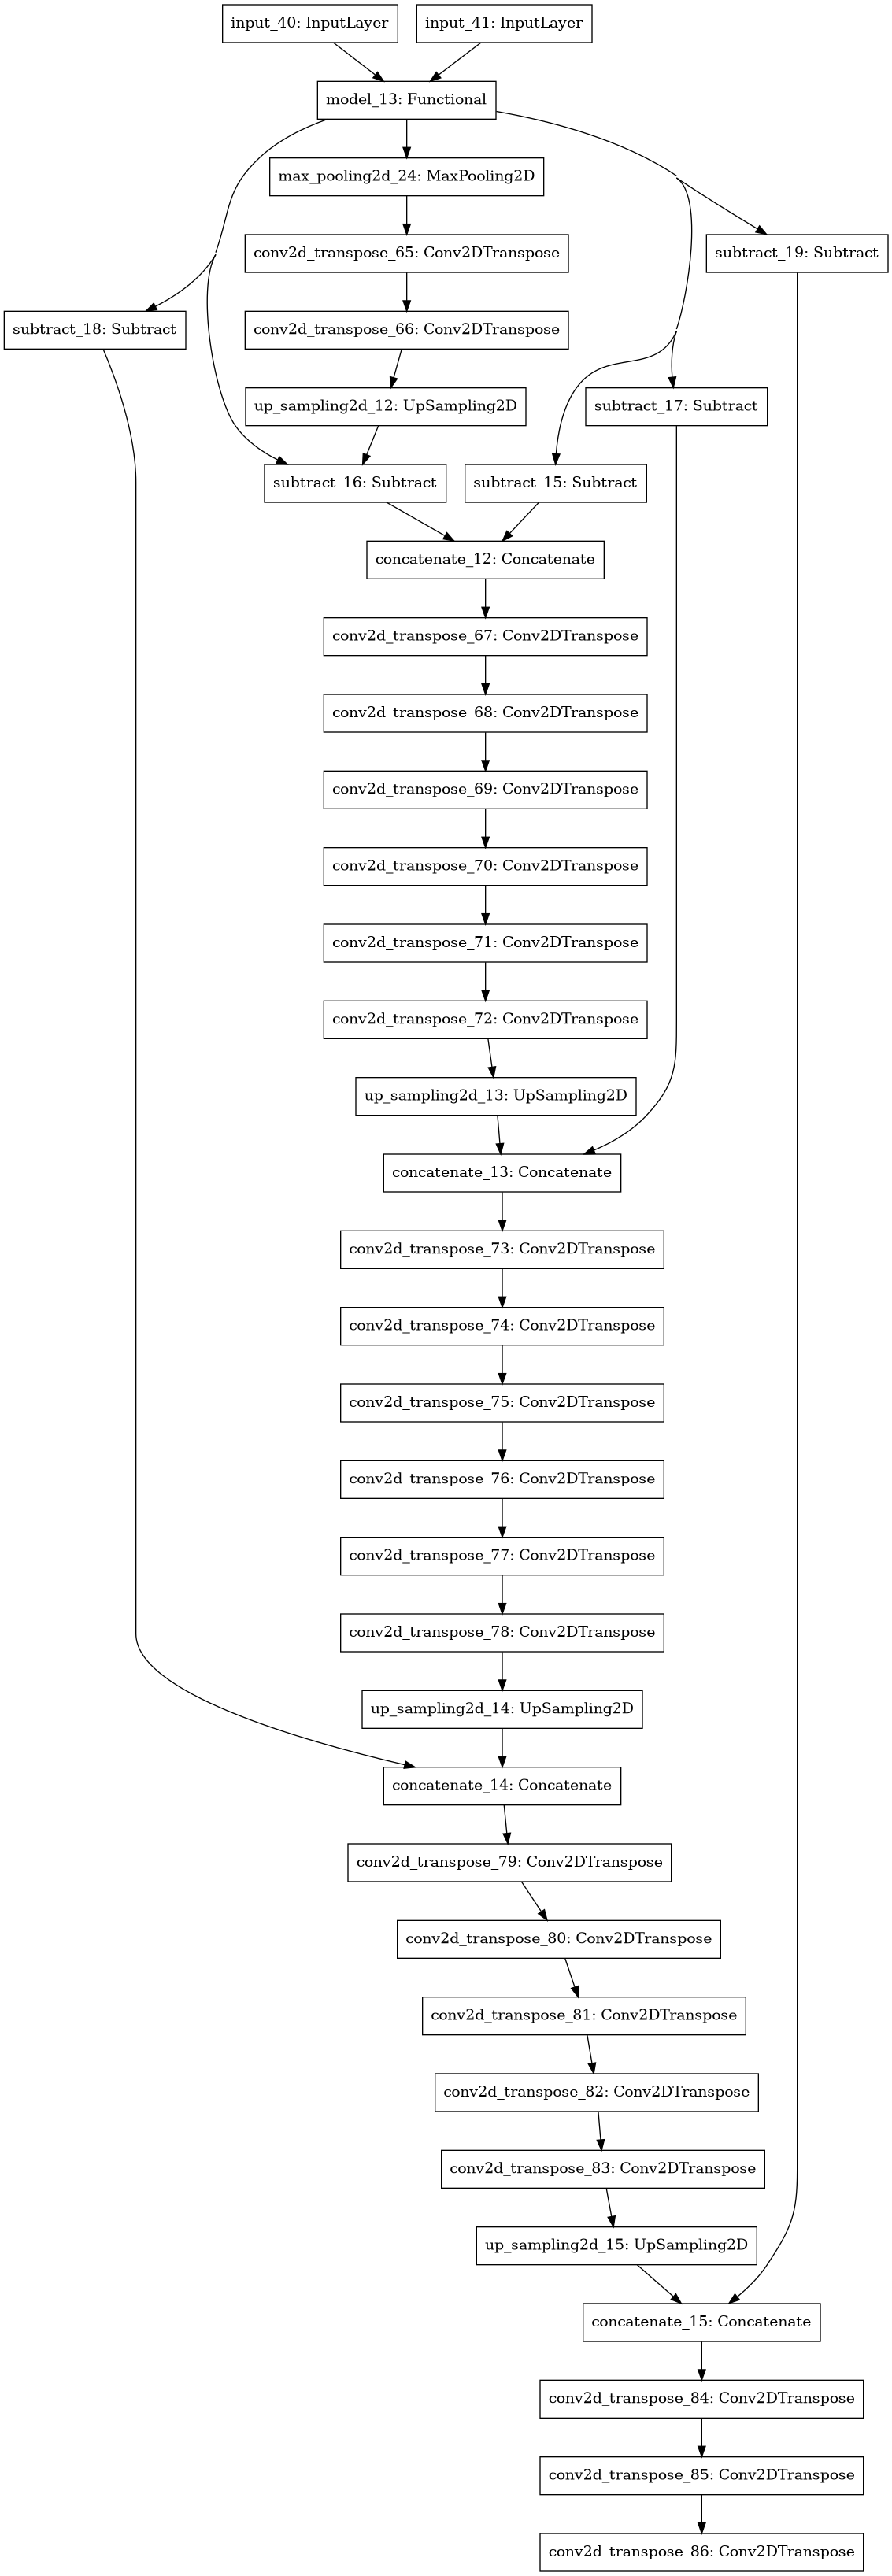

In [24]:
tf.keras.utils.plot_model(m)